In [2]:
import numpy as np
import pandas as pd
import mne

import matplotlib.pylab as plt

from src import data

plt.rcParams['figure.figsize'] = [10, 3]

!date -I

2024-03-08


# Apply source reconstruction to PyTepFit TMS-EEG data

In [3]:
path_pytepfit = 'external/pytepfit'

# load source estimates for both simulated and empirical data form PyTepFit data
sim_stc = mne.read_source_estimate(data.path(f'{path_pytepfit}/stc_sim_evoked_new'))
real_stc = mne.read_source_estimate(data.path(f'{path_pytepfit}/all_avg_high-stc'))

subjects_dir=data.path(f'{path_pytepfit}/')

In [15]:
# load source spaces form PyTepFit data
src = mne.read_source_spaces(data.path(f'{path_pytepfit}/fsaverage/fsaverage-src'), verbose=False)

/tmp/ipykernel_3622/1701538448.py:2: RuntimeWarning: This filename (/home/katterrina/fi_muni/0_diplomka/data/external/pytepfit/fsaverage/fsaverage-src) does not conform to MNE naming conventions. All source space files should end with -src.fif, -src.fif.gz, _src.fif, _src.fif.gz, -fwd.fif, -fwd.fif.gz, _fwd.fif, _fwd.fif.gz, -inv.fif, -inv.fif.gz, _inv.fif or _inv.fif.gz
  src = mne.read_source_spaces(data.path(f'{path_pytepfit}/fsaverage/fsaverage-src'), verbose=False)


In [17]:
# read labels for Schaefer parcellation from annotations
labels_Schaefer = mne.read_labels_from_annot('fsaverage',
                                             parc='Schaefer2018_200Parcels_7Networks_order', 
                                             subjects_dir=subjects_dir, 
                                             verbose=False)

# consider only labels without 'Background+FreeSurfer_Defined_Medial_Wall-lh' and '-rh
labels_Schaefer_relevant = labels_Schaefer[1:-1] 
len(labels_Schaefer_relevant)

200

In [18]:
# extract time course using Schaefer parcellation
real_label_ts = mne.extract_label_time_course(real_stc, labels_Schaefer_relevant, src, mode='mean_flip')
sim_label_ts = mne.extract_label_time_course(sim_stc, labels_Schaefer_relevant, src, mode='mean_flip')

Extracting time courses for 200 labels (mode: mean_flip)
Extracting time courses for 200 labels (mode: mean_flip)


In [19]:
sim_label_ts.shape

(200, 2000)

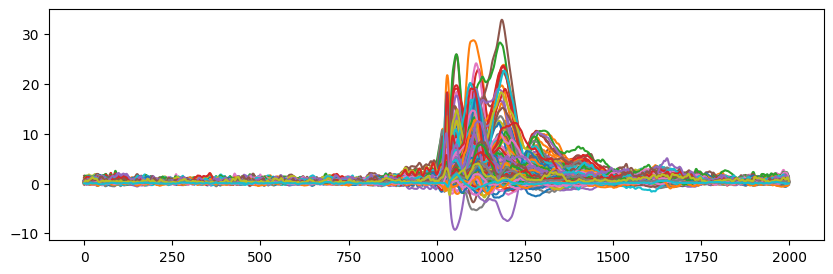

In [20]:
plt.plot(real_label_ts.T);

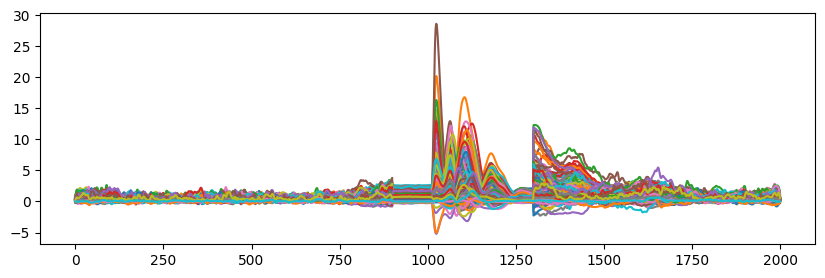

In [21]:
plt.plot(sim_label_ts.T);

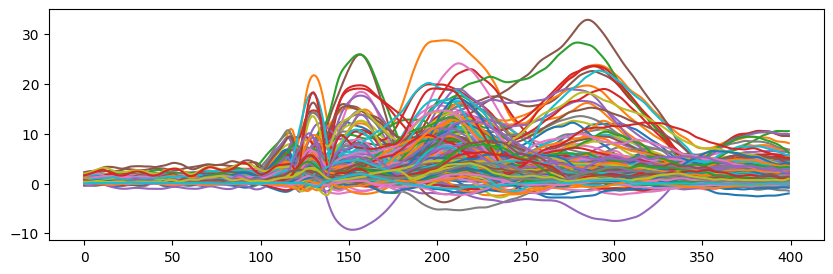

In [10]:
plt.plot(real_label_ts[:,900:1300].T);

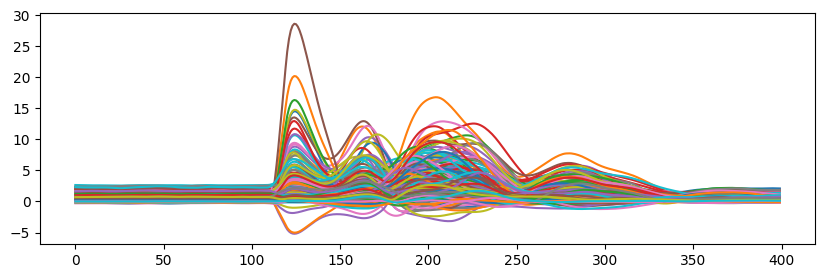

In [11]:
plt.plot(sim_label_ts[:,900:1300].T);

In [12]:
# extract names from Schaefer labels
ts_labels = np.array([l.name for l in labels_Schaefer_relevant])

In [13]:
np.savez(data.path(f'{path_pytepfit}/source_estimates/simulated.npz'), ts=sim_label_ts[:,900:1300].T, labels=ts_labels)

In [14]:
np.savez(data.path(f'{path_pytepfit}/source_estimates/empirical.npz'), ts=real_label_ts[:,900:1300].T, labels=ts_labels)

### Create CSV file with Schaefer label names and coordinates (centroids) corresponding to the data above

In [22]:
centroids_dict = dict()

for i in range(len(labels_Schaefer_relevant)):
    mne_vert = labels_Schaefer_relevant[i].center_of_mass(subjects_dir=subjects_dir)
    if ts_labels[i][10:12] == "LH":
        hemi = 0
    else:
        hemi = 1

    centroid = mne.vertex_to_mni(mne_vert,hemi,subject='fsaverage',subjects_dir=subjects_dir)
    centroids_dict[i] = [ts_labels[i],centroid[0],centroid[1],centroid[2]] 

centroids_df = pd.DataFrame.from_dict(centroids_dict, orient='index',columns=['ROI Name', 'R', 'A', 'S'])
centroids_df

,ROI Name,R,A,S
0,7Networks_LH_Cont_Cing_1-lh,-8.446814,-29.013483,28.885052
1,7Networks_LH_Cont_Cing_2-lh,-6.240661,2.739428,30.226892
2,7Networks_LH_Cont_PFCl_1-lh,-31.280493,38.780682,-8.203615
3,7Networks_LH_Cont_PFCl_2-lh,-39.062012,44.742603,-4.839688
4,7Networks_LH_Cont_PFCl_3-lh,-25.701366,47.526104,5.547397
...,...,...,...,...
195,7Networks_RH_Vis_5-rh,41.960854,-77.031326,-3.239134
196,7Networks_RH_Vis_6-rh,13.508061,-93.161369,-5.076058
197,7Networks_RH_Vis_7-rh,22.263935,-47.680222,-2.569446
198,7Networks_RH_Vis_8-rh,29.157928,-94.473122,-2.708371


In [26]:
centroids_file_path = data.path('external/schaefer_parcellation_centroids/Schaefer2018_200Parcels_7Networks.MNE.csv')
centroids_df.to_csv(centroids_file_path ,sep=',', index=False)